In [1]:
# TODO: convert to .py

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
im_path = 'test_data/test.png'
mask_path = 'make_bad_mask/test_cp_masks.png'

im = np.array(Image.open(im_path))
mask = np.array(Image.open(mask_path))

In [3]:
print(im.size)
print(mask.size)

37066611
12355537


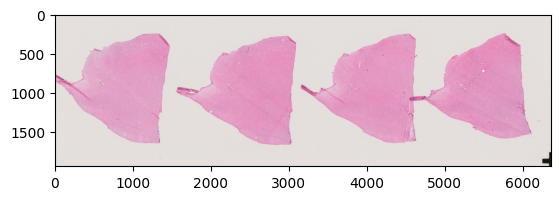

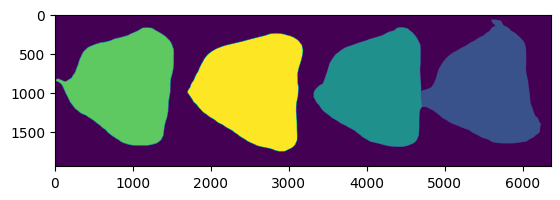

In [4]:
plt.imshow(im)
plt.show()
plt.imshow(mask)
plt.show()

In [5]:
def get_bounding_boxes(mask, margin=0):
    """
    Returns a dict mapping each non-zero label in `mask` to its
    bounding box extended by `margin`, clipped to image bounds.
    Boxes are returned in left-to-right order (by x_min).
    Each box is (x_min, x_max, y_min, y_max).
    """
    h, w = mask.shape
    bboxes = {}
    for obj_id in np.unique(mask)[1:]:
        rows, cols = np.where(mask == obj_id)
        if rows.size == 0:
            continue
        x_min, x_max = cols.min(), cols.max()
        y_min, y_max = rows.min(), rows.max()
        # extend with margin and clip
        x_min = max(0, x_min - margin)
        y_min = max(0, y_min - margin)
        x_max = min(w - 1, x_max + margin)
        y_max = min(h - 1, y_max + margin)
        bboxes[obj_id] = (x_min, x_max, y_min, y_max)

    # sort items by x_min (first element of box tuple)
    sorted_items = sorted(bboxes.items(), key=lambda item: item[1][0])
    # rebuild a dict (insertion order preserves left-to-right)
    return {obj_id: box for obj_id, box in sorted_items}

def crop_image_with_boxes(image, boxes, mask):
    """
    image:   HxWxC RGB array (or PIL Image convertible via np.asarray)
    boxes:   dict mapping obj_id → (x_min, x_max, y_min, y_max)
    mask:    HxW array of ints (e.g. 0/1 or labeled IDs)
    
    Returns dict of obj_id → cropped RGB array where:
      - mask==obj_id keeps original pixel
      - mask!=obj_id is filled with the channel-wise mode of those background pixels
    """
    img = np.asarray(image)
    if img.ndim < 2:
        raise ValueError(f"Expected ≥2D image, got ndim={img.ndim}")
    h, w = img.shape[:2]
    if mask.shape != (h, w):
        raise ValueError(f"mask shape {mask.shape} ≠ image shape {(h,w)}")
    
    crops = {}
    for obj_id, (x_min, x_max, y_min, y_max) in boxes.items():
        # sanity check
        if not (0 <= x_min <= x_max < w and 0 <= y_min <= y_max < h):
            raise ValueError(f"Box {obj_id} {(x_min,x_max,y_min,y_max)} out of bounds for image {h}×{w}")
        
        patch = img[y_min:y_max+1, x_min:x_max+1].copy()
        patch_mask = (mask[y_min:y_max+1, x_min:x_max+1] == obj_id)
        
        # For each channel, compute mode of background pixels
        if patch.ndim == 3:
            mode_color = []
            for c in range(patch.shape[2]):
                chan = patch[..., c]
                bg = chan[~patch_mask].ravel().astype(int)
                if bg.size:
                    counts = np.bincount(bg)
                    mode_color.append(int(counts.argmax()))
                else:
                    mode_color.append(0)
            mode_color = tuple(mode_color)
            # fill background
            patch[~patch_mask] = mode_color
        
        else:
            # grayscale fallback
            bg = patch[~patch_mask].ravel().astype(int)
            mode_val = int(np.bincount(bg).argmax()) if bg.size else 0
            patch[~patch_mask] = mode_val
        
        crops[obj_id] = patch

    return crops

In [6]:
boxes = get_bounding_boxes(mask, margin=50)
cropped_imgs = crop_image_with_boxes(im, boxes, mask)

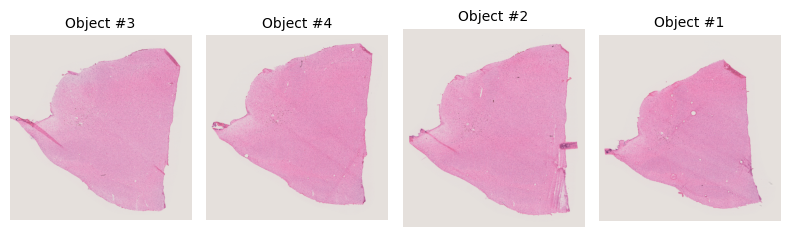

In [7]:
# cropped_imgs: dict obj_id → crop (H×W×C arrays)
n = len(cropped_imgs)
fig, axes = plt.subplots(1, n, figsize=(8, 8*n), squeeze=False)


for ax, (obj_id, crop) in zip(axes.ravel(), cropped_imgs.items()):
    ax.imshow(crop)
    ax.set_title(f'Object #{obj_id}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
plt.imshow(im)
plt.show()
plt.imshow(mask)
plt.show()